In [1]:
#starting data
import glob
import re
from pathlib import Path

trajectory_path = '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl'

block_files = glob.glob(str(Path(trajectory_path) / "blocks_*.h5"))

# Sort block files numerically based on block number
def extract_start_index(filename):
    match = re.search(r'blocks_(\d+)-\d+\.h5', filename)
    return int(match.group(1)) if match else -1

# Sort by the extracted start index
block_files_sorted = sorted(block_files, key=extract_start_index)

print(block_files_sorted)

#throw out first few blocks
block_files_sorted = block_files_sorted[5:]




['/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_0-499.h5', '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_500-999.h5', '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_1000-1002.h5', '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_1003-1003.h5', '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_1004-1004.h5', '/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmar

There are 8 chains, 4 copies of each chromosome. I will process as usual and then aggregate (should be 12,000 X12,000 at end)

Go from 48,000X3 to 48,000X48,000

something like this
for i in range pos[]

misc info
print(np.min(pos))  ->  -149.1
print(np.max(pos))  ->  100.55



In [3]:
import h5py
import numpy as np

# Get the first block file from your sorted list
first_block_file = block_files_sorted[0]
print(f"Examining file: {first_block_file}")

with h5py.File(first_block_file, 'r') as f:
    # Print the structure
    print("\nFile structure:")
    print("Groups:", list(f.keys()))
    
    # Get the first group name (which is '1006' in this case)
    first_group_name = list(f.keys())[0]
    print(f"\nFirst group name: {first_group_name}")
    
    # Access the group and its 'pos' dataset
    group = f[first_group_name]
    pos = group['pos'][:]  # [:] reads the entire dataset into memory
    
    print("\nPosition array shape:", pos.shape)
    print("Position array min:", np.min(pos))
    print("Position array max:", np.max(pos))

Examining file: /Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/custom_sticky_force_conf_cp_bl/blocks_1005-1005.h5

File structure:
Groups: ['1005']

First group name: 1005

Position array shape: (48000, 3)
Position array min: -32.37
Position array max: 32.63


In [4]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assume pos is a (48000, 3) numpy array
# Step 1: Compute the pairwise distance matrix
dist_matrix = squareform(pdist(pos))  # shape (48000, 48000)

# Step 2: Initialize best triplet and distance
best_triplet = None
min_total_dist = np.inf

# Step 3: Loop over each point and check closest two others
for i in range(len(pos)):
    # Get distances from point i to all others
    dists = dist_matrix[i]
    dists[i] = np.inf  # ignore self-distance

    # Find two nearest neighbors to i
    nearest = np.argpartition(dists, 2)[:2]
    
    # Compute total distance between the 3 points
    i1, i2 = nearest
    total_dist = dists[i1] + dists[i2] + dist_matrix[i1, i2]

    if total_dist < min_total_dist:
        min_total_dist = total_dist
        best_triplet = (i, i1, i2)

# Step 4: Print result
print("Closest triplet indices:", best_triplet)
print("Coordinates:\n", pos[list(best_triplet)])


Closest triplet indices: (5192, 29688, 29689)
Coordinates:
 [[-19.32 -13.1  -11.88]
 [-19.23 -13.08 -11.73]
 [-19.48 -12.9  -12.62]]


In [5]:
import time
import numpy as np
from scipy.spatial import cKDTree
import psutil
import os

# Start overall timer and memory monitor
start = time.time()
process = psutil.Process(os.getpid())

# --- Step 1: Build KDTree ---
t0 = time.time()
tree = cKDTree(pos)
t1 = time.time()
print(f"[Step 1] KDTree built in {t1 - t0:.2f} s")

# --- Step 2: Query pairs within cutoff ---
pairs = tree.query_pairs(r=2.5)
t2 = time.time()
print(f"[Step 2] Found {len(pairs)} pairs in {t2 - t1:.2f} s")

# --- Step 3: Build contact map ---
contact_map = np.zeros((48000, 48000), dtype=np.uint8)
for i, j in pairs:
    contact_map[i, j] = 1
    contact_map[j, i] = 1
t3 = time.time()
print(f"[Step 3] Contact map built in {t3 - t2:.2f} s")

# --- Memory reporting ---
print(f"\nContact map size (data only): {contact_map.nbytes / 1024**2:.2f} MB")
print(f"Total memory used by process: {process.memory_info().rss / 1024**2:.2f} MB")

# --- Total runtime ---
print(f"\nTotal runtime: {t3 - start:.2f} seconds")


[Step 1] KDTree built in 0.01 s
[Step 2] Found 535369 pairs in 0.08 s
[Step 3] Contact map built in 0.20 s

Contact map size (data only): 2197.27 MB
Total memory used by process: 19127.56 MB

Total runtime: 0.29 seconds


## Calculate contact map for all trajectories

Below code has weird behavior: Neighbors are not always contacting
Above comment was mistake - only 97 frames and ends don't always interact with next end

In [6]:
import h5py
import numpy as np
from scipy.spatial import cKDTree
import time
import os
import psutil

# --- Setup ---
cutoff = 2.5
n_particles = 48000
contact_sum = np.zeros((n_particles, n_particles), dtype=np.uint16)  # accumulate contacts
process = psutil.Process(os.getpid())
start_all = time.time()

print(f"\nProcessing {len(block_files_sorted)} blocks...\n")

# --- Loop through all block files ---
for idx, filepath in enumerate(block_files_sorted):
    with h5py.File(filepath, 'r') as f:
        group_name = list(f.keys())[0]
        pos = f[group_name]['pos'][:]

        # Sanity check shape
        assert pos.shape == (n_particles, 3), f"Unexpected shape in file {filepath}"

        t0 = time.time()
        tree = cKDTree(pos)
        pairs = tree.query_pairs(r=cutoff)
        t1 = time.time()

        # Temporary binary contact map
        contact_map = np.zeros((n_particles, n_particles), dtype=np.uint8)
        for i, j in pairs:
            contact_map[i, j] = 1
            contact_map[j, i] = 1

        contact_sum += contact_map

        print(f"[{idx+1}/{len(block_files_sorted)}] {os.path.basename(filepath)}: "
              f"{len(pairs)} contacts, time: {t1 - t0:.2f} s")

# --- Final contact frequency map ---
contact_freq = contact_sum.astype(np.float32) / len(block_files_sorted)

# --- Report ---
end_all = time.time()
print(f"\nAverage contact map computed across {len(block_files_sorted)} trajectories")
print(f"Shape: {contact_freq.shape}, dtype: {contact_freq.dtype}")
print(f"Peak contact frequency: {np.max(contact_freq):.3f}")
print(f"Total time: {end_all - start_all:.2f} seconds")
print(f"Memory used: {process.memory_info().rss / 1024**2:.2f} MB")

np.save('/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/contact_freq_48000.npy', contact_freq)


Processing 97 blocks...

[1/97] blocks_1005-1005.h5: 535369 contacts, time: 0.10 s
[2/97] blocks_1006-1006.h5: 536075 contacts, time: 0.09 s
[3/97] blocks_1007-1007.h5: 534790 contacts, time: 0.10 s
[4/97] blocks_1008-1008.h5: 535028 contacts, time: 0.09 s
[5/97] blocks_1009-1009.h5: 536371 contacts, time: 0.09 s
[6/97] blocks_1010-1010.h5: 534379 contacts, time: 0.09 s
[7/97] blocks_1011-1011.h5: 536292 contacts, time: 0.09 s
[8/97] blocks_1012-1012.h5: 533747 contacts, time: 0.09 s
[9/97] blocks_1013-1013.h5: 535800 contacts, time: 0.09 s
[10/97] blocks_1014-1014.h5: 536973 contacts, time: 0.09 s
[11/97] blocks_1015-1015.h5: 539303 contacts, time: 0.10 s
[12/97] blocks_1016-1016.h5: 535073 contacts, time: 0.09 s
[13/97] blocks_1017-1017.h5: 535752 contacts, time: 0.09 s
[14/97] blocks_1018-1018.h5: 535505 contacts, time: 0.09 s
[15/97] blocks_1019-1019.h5: 536781 contacts, time: 0.09 s
[16/97] blocks_1020-1020.h5: 533308 contacts, time: 0.09 s
[17/97] blocks_1021-1021.h5: 536100 con

### making contact matrix attempt 2

In [20]:
import h5py
import numpy as np
from scipy.spatial import cKDTree
import os
import psutil
import time

import h5py
import numpy as np
from scipy.spatial import cKDTree
import os
import psutil
import time

def compute_contact_map(block_files_sorted, cutoff=2.5, n_particles=48000, return_freq=False):
    contact_sum = np.zeros((n_particles, n_particles), dtype=np.uint16)
    process = psutil.Process(os.getpid())
    start_all = time.time()

    print(f"\nProcessing {len(block_files_sorted)} blocks with cutoff={cutoff}...\n")

    for idx, filepath in enumerate(block_files_sorted):
        with h5py.File(filepath, 'r') as f:
            group_name = list(f.keys())[0]
            pos = f[group_name]['pos'][:]
            assert pos.shape == (n_particles, 3), f"Unexpected shape in file {filepath}"

        # Neighbor check
        neighbor_dists = np.linalg.norm(pos[1:] - pos[:-1], axis=1)
        n_within_cutoff = np.sum(neighbor_dists < cutoff)

        # KD-tree
        t0 = time.time()
        tree = cKDTree(pos)
        pairs = tree.query_pairs(r=cutoff)
        t1 = time.time()

        # Missed bonded neighbors
        bonded_pairs = {(i, i+1) for i in range(n_particles - 1)}
        detected_pairs = set(pairs)
        missed_bonds = bonded_pairs - detected_pairs

        print(f"[{idx+1}/{len(block_files_sorted)}] {os.path.basename(filepath)}: "
              f"{len(pairs)} total pairs, {n_within_cutoff} neighbors < cutoff, "
              f"{len(missed_bonds)} bonded pairs missed, time: {t1 - t0:.2f}s")

        # Binary contact map
        contact_map = np.zeros((n_particles, n_particles), dtype=np.uint8)
        for i, j in pairs:
            contact_map[i, j] = 1
            contact_map[j, i] = 1

        contact_sum += contact_map

    end_all = time.time()

    print(f"\nContact map computation completed.")
    print(f"Shape: {contact_sum.shape}, max count: {np.max(contact_sum)}")
    print(f"Total time: {end_all - start_all:.2f} seconds")
    print(f"Memory used: {process.memory_info().rss / 1024**2:.2f} MB")

    if return_freq:
        contact_freq = contact_sum.astype(np.float32) / len(block_files_sorted)
        return contact_sum, contact_freq
    else:
        return contact_sum


contact_sum, contact_freq = compute_contact_map(block_files_sorted, cutoff=2.5, return_freq=True)



Processing 97 blocks with cutoff=2.5...

[1/97] blocks_1005-1005.h5: 535369 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.09s
[2/97] blocks_1006-1006.h5: 536075 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.10s
[3/97] blocks_1007-1007.h5: 534790 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.10s
[4/97] blocks_1008-1008.h5: 535028 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.08s
[5/97] blocks_1009-1009.h5: 536371 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.09s
[6/97] blocks_1010-1010.h5: 534379 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.09s
[7/97] blocks_1011-1011.h5: 536292 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.10s
[8/97] blocks_1012-1012.h5: 533747 total pairs, 47992 neighbors < cutoff, 7 bonded pairs missed, time: 0.09s
[9/97] blocks_1013-1013.h5: 535800 total pairs, 47992 neighbors < cutoff, 7 bonded pai

In [21]:
np.save('/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/contact_freq_48000.npy', contact_freq)
np.save('/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/contact_sum_48000.npy', contact_sum)

## visualize contact map

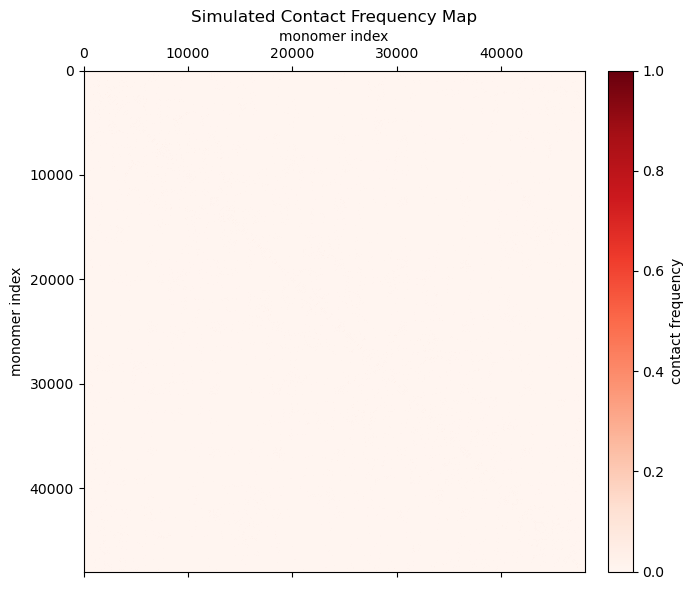

In [27]:
import matplotlib.pyplot as plt
contact_freq = np.load('/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/contact_freq_48000.npy')

f, ax = plt.subplots(figsize=(7,6))
im = ax.matshow(contact_freq, vmax=1.0, cmap='Reds')  # adjust vmax as needed
plt.colorbar(im, fraction=0.046, pad=0.04, label='contact frequency')
ax.set_xlabel('monomer index')
ax.set_ylabel('monomer index')
ax.set_title('Simulated Contact Frequency Map')
ax.xaxis.set_label_position('top')
plt.tight_layout()

#want counts not frequencies

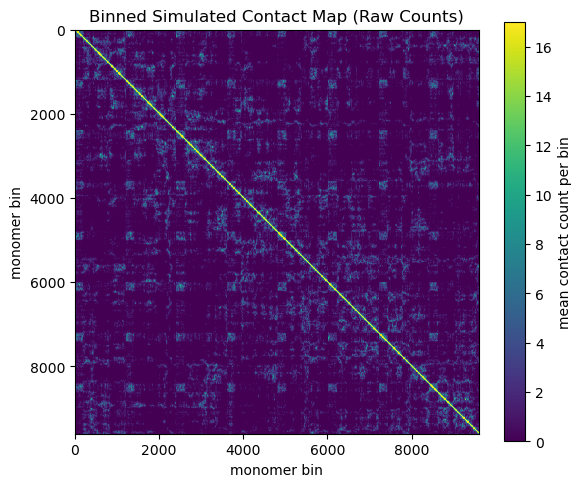

In [34]:
def bin_matrix(matrix, bin_size):
    """Downsample matrix by block-summing over bin_size × bin_size chunks (no averaging)."""
    assert matrix.shape[0] == matrix.shape[1], "Matrix must be square"
    n = matrix.shape[0]
    n_bins = n // bin_size
    matrix = matrix[:n_bins*bin_size, :n_bins*bin_size]  # crop to divisible
    reshaped = matrix.reshape(n_bins, bin_size, n_bins, bin_size)
    binned = reshaped.sum(axis=(1, 3))  # sum, not mean
    return binned

binned_contact = bin_matrix(contact_sum, bin_size=5)

plt.figure(figsize=(6, 5))
plt.imshow(binned_contact, cmap='viridis', vmax=np.percentile(binned_contact, 99))
plt.colorbar(label='mean contact count per bin')
plt.title('Binned Simulated Contact Map (Raw Counts)')
plt.xlabel('monomer bin')
plt.ylabel('monomer bin')
plt.tight_layout()

In [30]:
print(np.max(contact_sum))
print(np.count_nonzero(contact_sum))
print(np.sum(contact_sum))

print(np.max(binned_contact))
print(np.percentile(binned_contact, 99))

97
66268430
103976274
97
1.0


In [25]:
import numpy as np

# Check just the immediate neighbors: (i, i+1)
neighbor_freqs = np.diag(contact_freq, k=1)  # upper diagonal
neighbor_freqs_rev = np.diag(contact_freq, k=-1)  # lower diagonal

# Combine both to check symmetry
all_neighbor_freqs = np.concatenate([neighbor_freqs, neighbor_freqs_rev])

# ✅ Check if all equal to 1
print("Min neighbor contact frequency:", np.min(all_neighbor_freqs))
print("Max neighbor contact frequency:", np.max(all_neighbor_freqs))
print("Are all neighbor contacts = 1.0?", np.allclose(all_neighbor_freqs, 1.0))


Min neighbor contact frequency: 0.0
Max neighbor contact frequency: 1.0
Are all neighbor contacts = 1.0? False


## process replicates into consensus matrices

In [37]:
# Chromosome layout
chain_starts = np.arange(0, 48000 + 1, 6000)
n_chains = len(chain_starts) - 1

# Assume contact_sum is full 48000x48000 matrix
chr1_matrices = []
chr2_matrices = []

for i in range(n_chains):
    start = chain_starts[i]
    end = chain_starts[i + 1]
    submatrix = contact_sum[start:end, start:end]

    if i < 4:
        chr1_matrices.append(submatrix)
    else:
        chr2_matrices.append(submatrix)

# Average over copies
chr1_consensus = np.sum(chr1_matrices, axis=0)  # or np.mean(...) if you'd prefer
chr2_consensus = np.sum(chr2_matrices, axis=0)


In [14]:
import numpy as np
import pandas as pd
import cooler
import h5py

# Load full matrix
contact_sum = np.load("/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/chromosomes_openmm/polychrom_base/benchmarking/hp_traj_cones_bm/contact_sum_48000.npy")
bin_size_bp = 40_000

# Constants
copies_per_chrom = 4
chain_len = 6000
total_len = chain_len * 2  # 12000 for final matrix

# Create consensus matrix (12000 x 12000)
consensus_matrix = np.zeros((total_len, total_len), dtype=np.float32)

# Sum chr1-chr1 interactions (top-left quadrant)
for i in range(4):
    for j in range(4):
        block = contact_sum[i*chain_len:(i+1)*chain_len, j*chain_len:(j+1)*chain_len]
        consensus_matrix[:chain_len, :chain_len] += block

# Sum chr2-chr2 interactions (bottom-right quadrant)
for i in range(4):
    for j in range(4):
        block = contact_sum[(i+4)*chain_len:(i+5)*chain_len, (j+4)*chain_len:(j+5)*chain_len]
        consensus_matrix[chain_len:, chain_len:] += block

# Sum chr1-chr2 interactions (top-right and bottom-left quadrants)
for i in range(4):
    for j in range(4):
        # Top-right quadrant
        block = contact_sum[i*chain_len:(i+1)*chain_len, (j+4)*chain_len:(j+5)*chain_len]
        consensus_matrix[:chain_len, chain_len:] += block
        # Bottom-left quadrant (transpose of top-right)
        consensus_matrix[chain_len:, :chain_len] += block.T

# Function to convert matrix to pixel format
def matrix_to_pixels(matrix, tril=False):
    i, j = np.triu_indices(matrix.shape[0]) if not tril else np.tril_indices(matrix.shape[0])
    counts = matrix[i, j]
    mask = counts > 0
    return pd.DataFrame({
        'bin1_id': i[mask],
        'bin2_id': j[mask],
        'count': counts[mask]
    })

# Create bins for 40kb resolution
bins_chr1 = pd.DataFrame({
    'chrom': ['sim_chr1'] * chain_len,
    'start': np.arange(chain_len) * bin_size_bp,
    'end': (np.arange(chain_len) + 1) * bin_size_bp
})
bins_chr2 = pd.DataFrame({
    'chrom': ['sim_chr2'] * chain_len,
    'start': np.arange(chain_len) * bin_size_bp,
    'end': (np.arange(chain_len) + 1) * bin_size_bp
})
all_bins_df = pd.concat([bins_chr1, bins_chr2], ignore_index=True)

# Convert to pixels for 40kb resolution
pixels_df = matrix_to_pixels(consensus_matrix)

# Create base cooler at 40kb resolution
cooler.create_cooler(
    cool_uri="hp_sim_cones_consensus_40kb.cool",
    bins=all_bins_df,
    pixels=pixels_df,
    dtypes={'count': 'float32'},
    symmetric_upper=True
)

# Create 200kb resolution by summing 5x5 blocks
block_size = 5
new_chain_len = chain_len // block_size
new_total_len = total_len // block_size

# Create new matrix for 200kb resolution
coarse_matrix = np.zeros((new_total_len, new_total_len), dtype=np.float32)

# Sum blocks for each quadrant
for i in range(new_total_len):
    for j in range(new_total_len):
        block = consensus_matrix[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
        coarse_matrix[i, j] = np.sum(block)

# Create bins for 200kb resolution
bins_chr1_coarse = pd.DataFrame({
    'chrom': ['sim_chr1'] * new_chain_len,
    'start': np.arange(new_chain_len) * (bin_size_bp * block_size),
    'end': (np.arange(new_chain_len) + 1) * (bin_size_bp * block_size)
})
bins_chr2_coarse = pd.DataFrame({
    'chrom': ['sim_chr2'] * new_chain_len,
    'start': np.arange(new_chain_len) * (bin_size_bp * block_size),
    'end': (np.arange(new_chain_len) + 1) * (bin_size_bp * block_size)
})
all_bins_coarse_df = pd.concat([bins_chr1_coarse, bins_chr2_coarse], ignore_index=True)

# Convert to pixels for 200kb resolution
pixels_coarse_df = matrix_to_pixels(coarse_matrix)

# Create 200kb resolution cooler
cooler.create_cooler(
    cool_uri="hp_sim_cones_consensus_200kb.cool",
    bins=all_bins_coarse_df,
    pixels=pixels_coarse_df,
    dtypes={'count': 'float32'},
    symmetric_upper=True
)

# Create multi-resolution cooler
cooler.zoomify_cooler(
    ["hp_sim_cones_consensus_40kb.cool"],
    "hp_sim_cones_consensus.mcool",
    resolutions=[40000, 200000],
    nproc=1,
    chunksize=10000000
)

print("Multi-resolution cooler file created: hp_sim_cones_consensus.mcool") 

Multi-resolution cooler file created: hp_sim_cones_consensus.mcool


## visualize simulation with cooler

In [15]:
cooler.fileops.list_coolers(f'hp_sim_cones_consensus.mcool')

['/resolutions/40000', '/resolutions/200000']

In [16]:
clr = cooler.Cooler("hp_sim_cones_consensus.mcool::resolutions/200000")
print(f'chromosomes: {clr.chromnames}, binsize: {clr.binsize}')

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

chromosomes: ['sim_chr1', 'sim_chr2'], binsize: 200000
sim_chr1 : (0, 1200)
sim_chr2 : (1200, 2400)


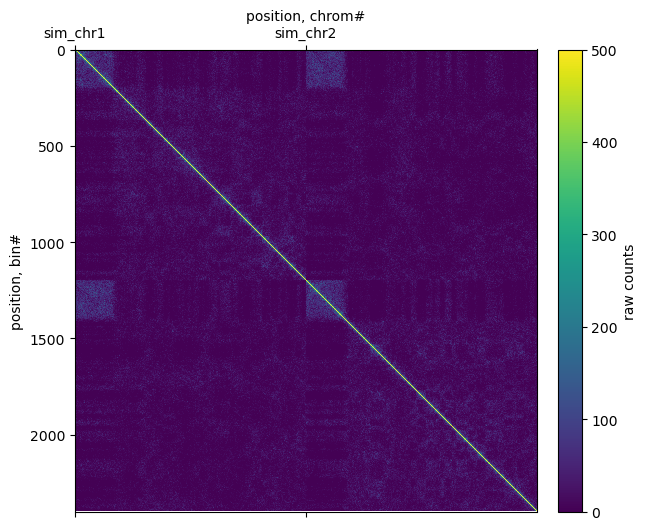

In [24]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(
    figsize=(7,6))
im = ax.matshow((clr.matrix(balance=False)[:]),vmax=500);
plt.colorbar(im ,fraction=0.046, pad=0.04, label='raw counts')
ax.set(xticks=chromstarts, xticklabels=clr.chromnames,
       xlabel='position, chrom#', ylabel='position, bin#')
ax.xaxis.set_label_position('top')

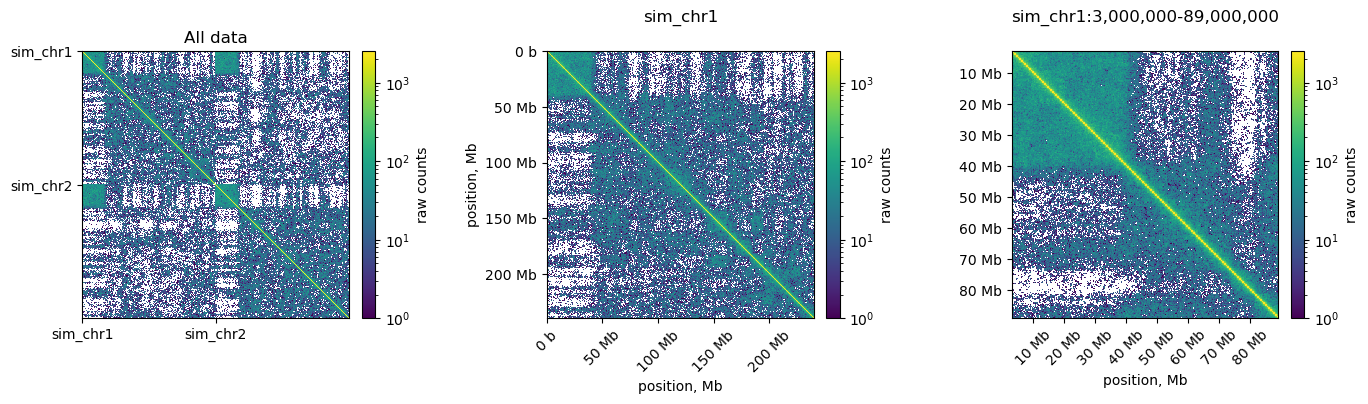

In [23]:
# plot heatmaps at megabase resolution with 3 levels of zoom in log-scale with a consistent colormap#
from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

f, axs = plt.subplots(
    figsize=(14,4),
    ncols=3)
bp_formatter = EngFormatter('b')
norm = LogNorm(vmax=2500)

ax = axs[0]
im = ax.matshow(
    clr.matrix(balance=False)[:],
    norm=norm,
)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_xticks(chromstarts)
ax.set_xticklabels(clr.chromnames)
ax.set_yticks(chromstarts)
ax.set_yticklabels(clr.chromnames)
ax.xaxis.tick_bottom()
ax.set_title('All data')

ax = axs[1]
im = ax.matshow(
    clr.matrix(balance=False).fetch('sim_chr1'),
    norm=norm,
    extent=(0,clr.chromsizes['sim_chr1'], clr.chromsizes['sim_chr1'], 0)
);
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set_title('sim_chr1', y=1.08)
ax.set(ylabel='position, Mb', xlabel='position, Mb')
format_ticks(ax)

ax = axs[2]
start, end = 3_000_000, 89_000_000
region = ('sim_chr1', start, end)
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm=norm,
    extent=(start, end, end, start)
);
ax.set_title(f'sim_chr1:{start:,}-{end:,}', y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');
ax.set(xlabel='position, Mb')
format_ticks(ax)
plt.tight_layout()

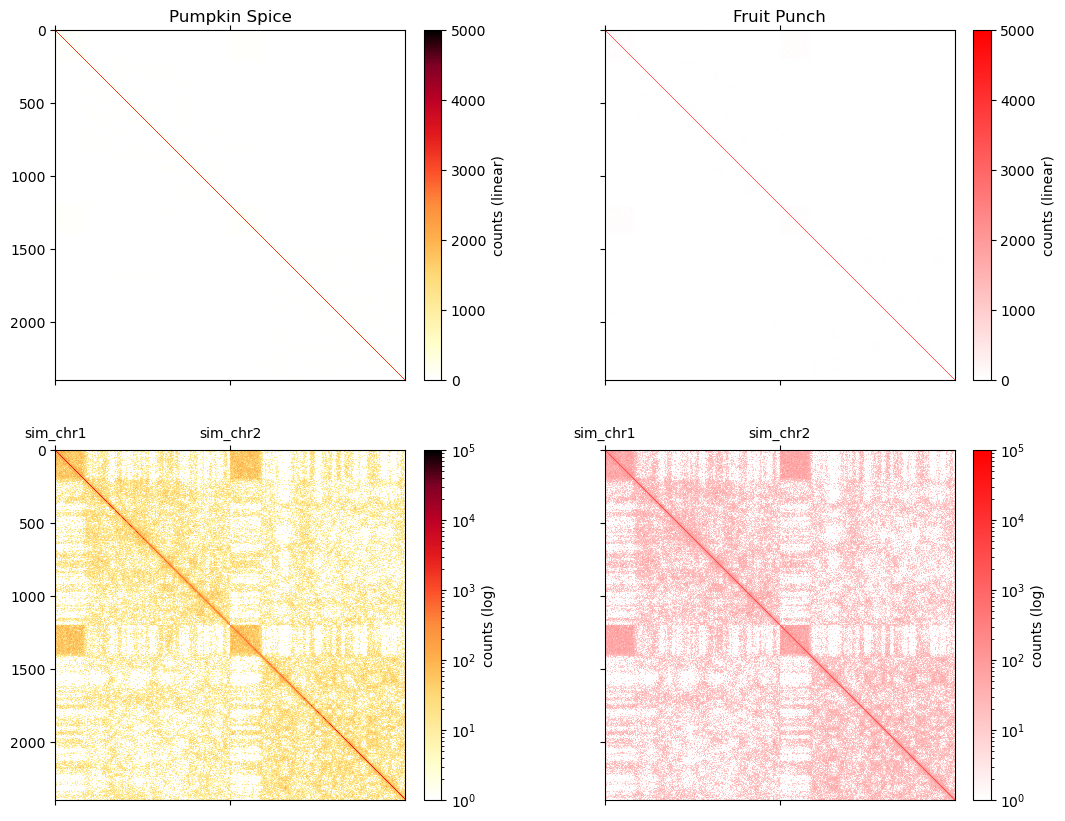

In [25]:
    ### plot the corrected data in fall heatmap and compare to the white-red colormap ###
### thanks for the alternative collormap naming to https://twitter.com/HiC_memes/status/1286326919122825221/photo/1###
import cooltools.lib.plotting
import seaborn as sns
vmax = 5000
norm = LogNorm(vmin=1, vmax=100_000)
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2,
    ncols=2,
    sharex=True, sharey=True)

ax = axs[0, 0]
ax.set_title('Pumpkin Spice')
im = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap='fall');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[0, 1]
ax.set_title('Fruit Punch')
im3 = ax.matshow(clr.matrix(balance=False)[:], vmax=vmax, cmap=fruitpunch);
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (linear)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 0]
im = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap='fall');
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

ax = axs[1, 1]
im3 = ax.matshow(clr.matrix(balance=False)[:], norm=norm, cmap=fruitpunch);
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='counts (log)');
plt.xticks(chromstarts,clr.chromnames);

In [27]:
# For the first visualization (working one)
matrix1 = clr.matrix(balance=False).fetch(('sim_chr1', start, end))
print("First visualization (working):")
print(f"Data range: {matrix1.min()} - {matrix1.max()}")
print(f"Non-zero values: {np.sum(matrix1 > 0)} out of {matrix1.size}")
print(f"99th percentile: {np.percentile(matrix1[matrix1 > 0], 99)}")
print("\n")

# For the second visualization (problematic one)
matrix2 = clr.matrix(balance=False).fetch(region)
print("Second visualization:")
print(f"Data range: {matrix2.min()} - {matrix2.max()}")
print(f"Non-zero values: {np.sum(matrix2 > 0)} out of {matrix2.size}")
print(f"99th percentile: {np.percentile(matrix2[matrix2 > 0], 99)}")

First visualization (working):
Data range: 0.0 - 3317.0
Non-zero values: 155862 out of 184900
99th percentile: 685.0


Second visualization:
Data range: 0.0 - 3317.0
Non-zero values: 155862 out of 184900
99th percentile: 685.0


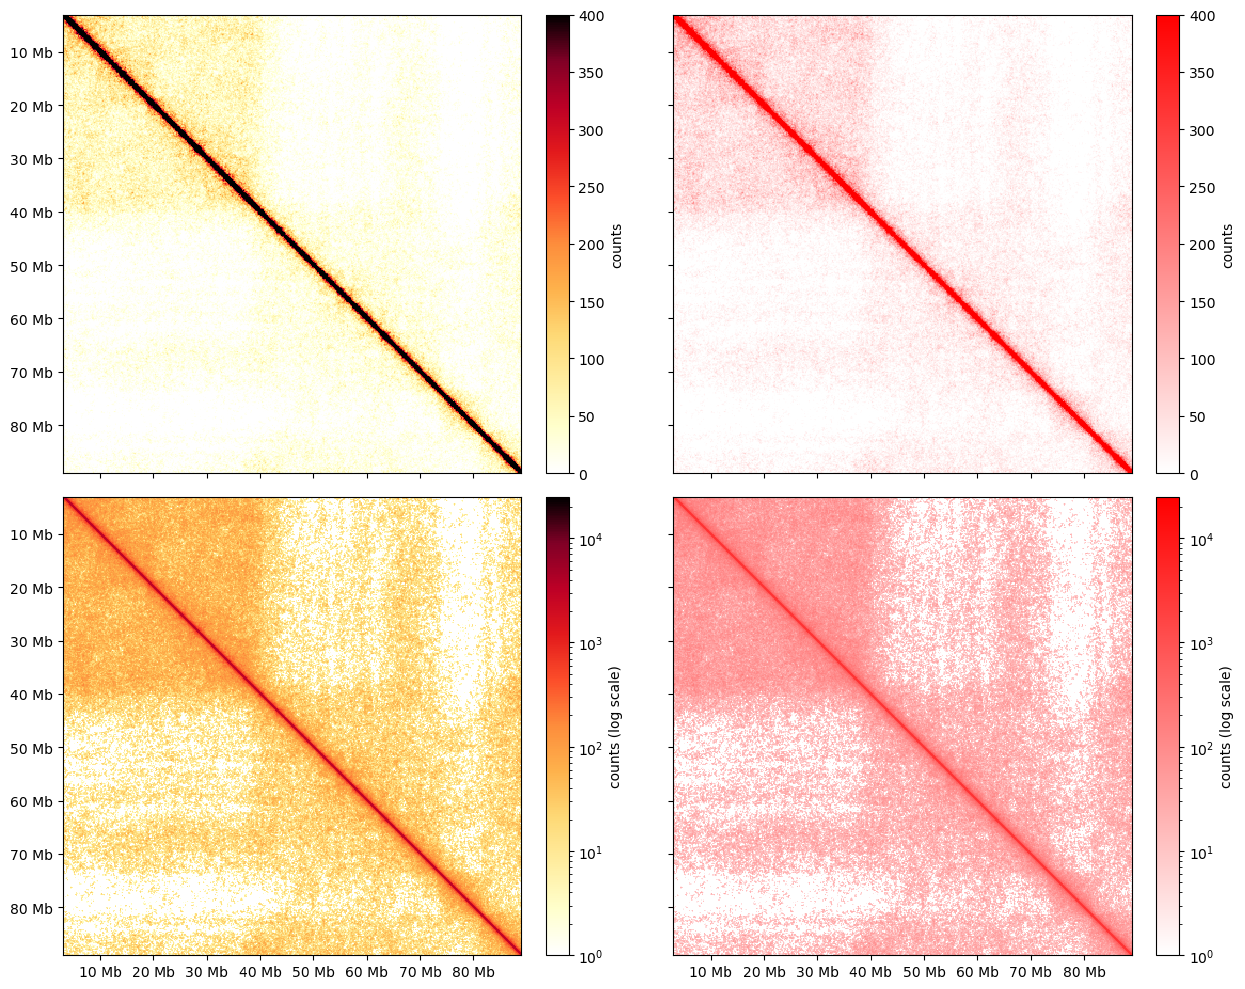

In [38]:
### plot the corrected data in fall heatmap ###
import cooltools.lib.plotting
clr_2000kb = cooler.Cooler(f'/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/github/genome_organization/src/utilis/hp_sim_cones_consensus.mcool::resolutions/200000')

region = 'sim_chr1:3,000,000-89,000,000'
extents = (start, end, end, start)
norm = LogNorm(vmax=25000)  # Match the working visualization

f, axs = plt.subplots(
    figsize=(13, 10),
    nrows=2,
    ncols=2,
    sharex=True,
    sharey=True
)

# Linear scale plots
ax = axs[0, 0]
im = ax.matshow(
    clr_2000kb.matrix(balance=False).fetch(region),
    cmap='fall',
    vmax=400,  # Match the working visualization
    extent=extents
)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='counts')

ax = axs[0, 1]
im2 = ax.matshow(
    clr_2000kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch,
    vmax=400,  # Match the working visualization
    extent=extents
)
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts')

# Log scale plots
ax = axs[1, 0]
im = ax.matshow(
    clr_2000kb.matrix(balance=False).fetch(region),
    cmap='fall',
    norm=norm,  # Using same norm as working visualization
    extent=extents
)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='counts (log scale)')

ax = axs[1, 1]
im2 = ax.matshow(
    clr_2000kb.matrix(balance=False).fetch(region),
    cmap=fruitpunch,
    norm=norm,  # Using same norm as working visualization
    extent=extents
)
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='counts (log scale)')

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()

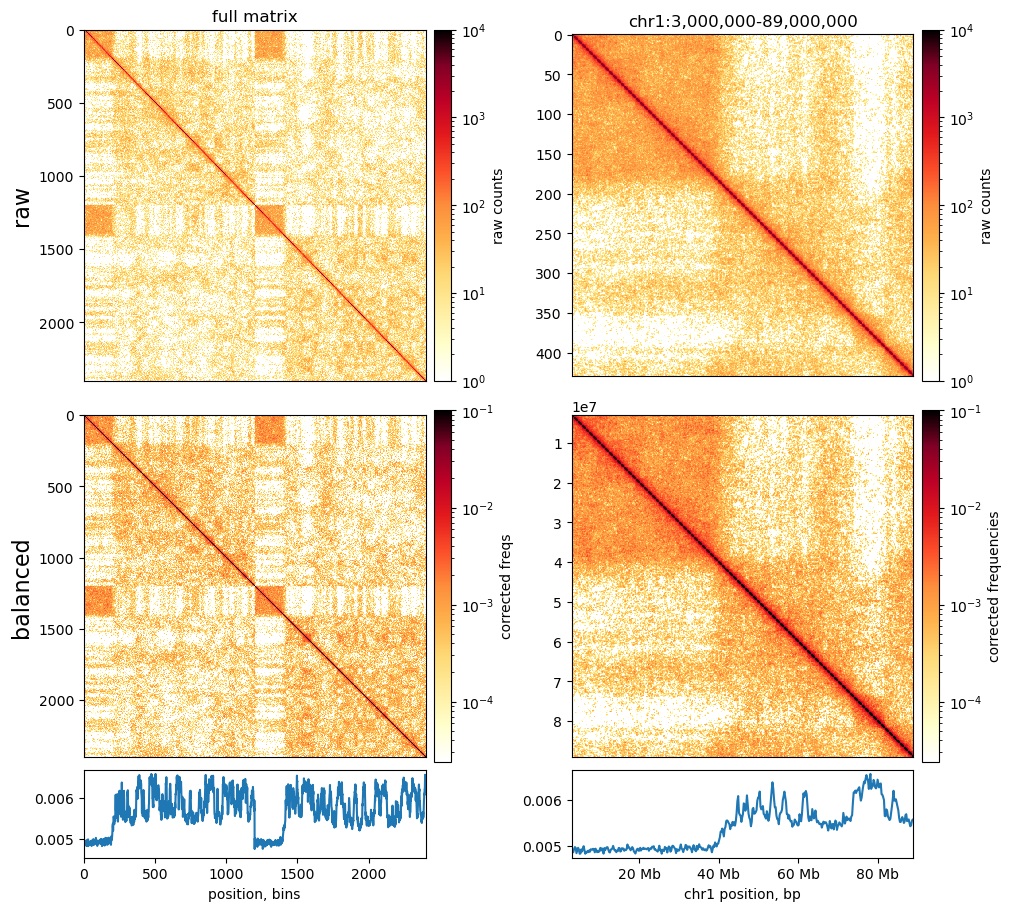

In [39]:
# First load and balance both coolers

clr = cooler.Cooler(f'/Users/kadendimarco/Desktop/Shrivinas_lab/genome_archetecture/github/genome_organization/src/utilis/hp_sim_cones_consensus.mcool::resolutions/200000')

weights = cooler.balance_cooler(clr, store=True, store_name='weight')

### plot the raw and corrected data in logscale ###
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt_width = 4
f, axs = plt.subplots(
    figsize=(plt_width+plt_width+2, plt_width+plt_width+1),
    ncols=4,
    nrows=3,
    gridspec_kw={'height_ratios':[4,4,1], "wspace":0.01, 'width_ratios':[1,.05,1,.05]},
    constrained_layout=True
)

norm = LogNorm(vmax=0.1)
norm_raw = LogNorm(vmin=1, vmax=10_000)

# First main plot (raw)
ax = axs[0,0]
im = ax.matshow(
    clr.matrix(balance=False)[:],
    norm=norm_raw,
    cmap='fall',
    aspect='auto'
)
ax.xaxis.set_visible(False)
ax.set_title('full matrix')
ax.set_ylabel('raw', fontsize=16)

cax = axs[0,1]
plt.colorbar(im, cax=cax, label='raw counts')

# Second main plot (balanced)
ax = axs[1,0]
im = ax.matshow(
    clr.matrix()[:],
    norm=norm,
    cmap='fall',
)
ax.xaxis.set_visible(False)
ax.set_ylabel('balanced', fontsize=16)

cax = axs[1,1]
plt.colorbar(im, cax=cax, label='corrected freqs')

# Weights plot for main matrix
ax1 = axs[2,0]
weights = clr.bins()[:]['weight'].values
ax1.plot(weights)
ax1.set_xlim([0, len(clr.bins()[:])])
ax1.set_xlabel('position, bins')

ax1 = axs[2,1]
ax1.set_visible(False)

# Region-specific plots
start = 3_000_000
end = 89_000_000
region = ('sim_chr1', start, end)

# Raw region plot
ax = axs[0,2]
im = ax.matshow(
    clr.matrix(balance=False).fetch(region),
    norm=norm_raw,
    cmap='fall'
)
ax.set_title(f'chr1:{start:,}-{end:,}')
ax.xaxis.set_visible(False)

cax = axs[0,3]
plt.colorbar(im, cax=cax, label='raw counts')

# Balanced region plot
ax = axs[1,2]
im = ax.matshow(
    clr.matrix().fetch(region),
    norm=norm,
    cmap='fall',
    extent=(start, end, end, start)
)
ax.xaxis.set_visible(False)

cax = axs[1,3]
plt.colorbar(im, cax=cax, label='corrected frequencies')

# Weights plot for region
ax1 = axs[2,2]
weights = clr.bins().fetch(region)['weight'].values
ax1.plot(
    np.linspace(start, end, len(weights)),
    weights
)
format_ticks(ax1, y=False, rotate=False)
ax1.set_xlim(start, end)
ax1.set_xlabel('chr1 position, bp')

ax1 = axs[2,3]
ax1.set_visible(False)

/Users/kadendimarco/.local/share/mamba/envs/polychrom/lib/python3.10/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur


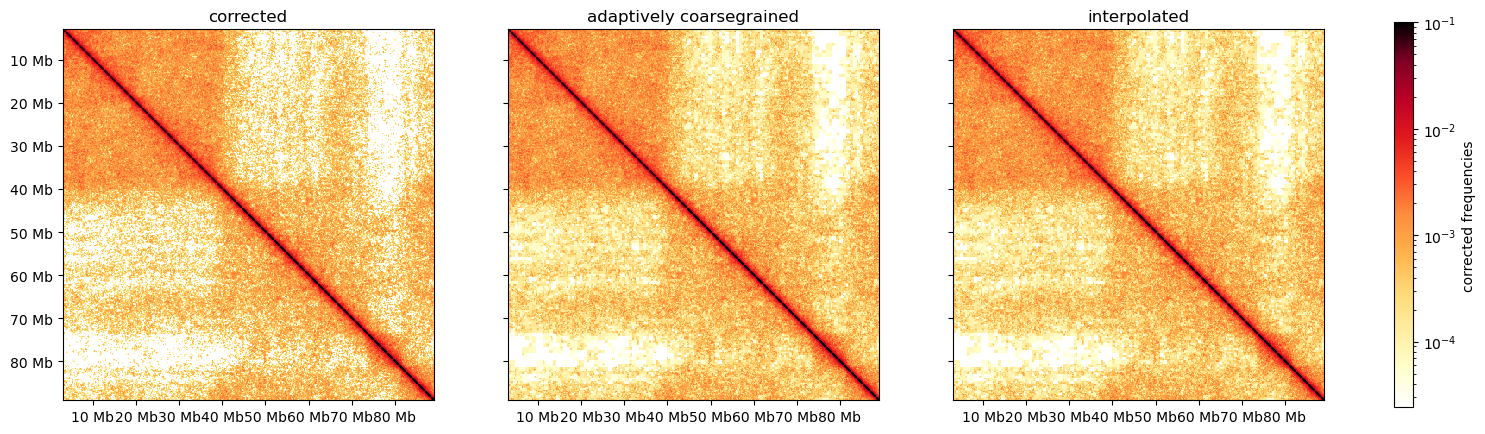

In [40]:
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan

start = 3_000_000
end = 89_000_000
region = ('sim_chr1', start, end)
extents = (start, end, end, start)

cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)

cgi = interp_nan(cg)

f, axs = plt.subplots(
    figsize=(18,5),
    nrows=1,
    ncols=3,
    sharex=True, sharey=True)

ax = axs[0]
im = ax.matshow(clr.matrix(balance=True).fetch(region), cmap='fall', norm=norm, extent=extents)
ax.set_title('corrected')

ax = axs[1]
im2 = ax.matshow(cg, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'adaptively coarsegrained')

ax = axs[2]
im3 = ax.matshow(cgi, cmap='fall', norm=norm, extent=extents)
ax.set_title(f'interpolated')

for ax in axs:
    format_ticks(ax, rotate=False)

plt.colorbar(im3, ax=axs, fraction=0.046, label='corrected frequencies')